In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.optim as optim
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
from tensorflow.keras import layers, models
import torch
import numpy as np
import math
from sklearn.model_selection import StratifiedShuffleSplit

# Load dataset
data = fetch_california_housing()
X, y = data.data, data.target  # Features and target

# Shuffle and split data
X, y = np.random.permutation(X), np.random.permutation(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [2]:
#created the calibration set and the proper training set
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move tensors to the selected device (GPU or CPU)
X_train_normal = X_train.clone()
y_train_normal = y_train.clone()
X_test_normal = X_test.clone()
y_test_normal = y_test.clone()


X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

X_train, X_full_calib, y_train, y_full_calib = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [3]:
def repeat_sampling(num_epochs, sample_size):
    def decorator(func):
        def wrapper(X_full_calib, y_full_calib, *args, **kwargs):
            all_coverages = []
            N = X_full_calib.shape[0]

            for epoch in range(num_epochs):
                torch.manual_seed(epoch)  # Reproducible sampling
                indices = torch.randperm(N)

                calib_idx = indices[:sample_size]

                X_calib = X_full_calib[calib_idx]
                y_calib = y_full_calib[calib_idx]
                coverage = func(
                    X_calib, y_calib,
                    X_test, y_test,
                    *args, **kwargs
                )
                all_coverages.append(coverage)

            mean_coverage = np.mean(all_coverages, axis=0)
            return mean_coverage
        return wrapper
    return decorator


In [4]:
exp_iter = 500
exp_sample_size = 1000

In [5]:
def quantile_loss(y_pred, y_true, tau):
    errors = y_true - y_pred
    return torch.mean(torch.max(tau * errors, (tau - 1) * errors))


In [6]:
def get_coverage_quantile_regression(alpha):
    input_dim = X_train.shape[1]

    W_lower = torch.randn((input_dim, 1), requires_grad=True, dtype=torch.float32, device=device)
    b_lower = torch.zeros(1, requires_grad=True, dtype=torch.float32, device=device)

    W_upper = torch.randn((input_dim, 1), requires_grad=True, dtype=torch.float32, device=device)
    b_upper = torch.zeros(1, requires_grad=True, dtype=torch.float32, device=device)

    # Hyperparameters
    taus = [alpha / 2, 1 - alpha / 2]  # Lower and Upper Quantiles
    epochs = 500
    lr = 0.01

    # Optimizers
    opt_lower = optim.Adam([W_lower, b_lower], lr=lr)
    opt_upper = optim.Adam([W_upper, b_upper], lr=lr)

    for epoch in range(epochs):
        # Lower Quantile Model (tau = alpha/2)
        opt_lower.zero_grad()
        y_pred_lower = torch.matmul(X_train, W_lower) + b_lower
        loss_lower = quantile_loss(y_pred_lower, y_train, taus[0])
        loss_lower.backward()
        opt_lower.step()

        # Upper Quantile Model (tau = 1-alpha/2)
        opt_upper.zero_grad()
        y_pred_upper = torch.matmul(X_train, W_upper) + b_upper
        loss_upper = quantile_loss(y_pred_upper, y_train, taus[1])
        loss_upper.backward()
        opt_upper.step()

    @repeat_sampling(num_epochs=exp_iter, sample_size=exp_sample_size)
    def calc_cvg(X_cal, y_cal, X_test, y_test):
        # Move tensors to device
        X_cal = X_cal.to(device)
        y_cal = y_cal.to(device)

        y_lower_pred = torch.matmul(X_cal, W_lower).detach()
        y_upper_pred = torch.matmul(X_cal, W_upper).detach()

        score_array = torch.maximum(y_lower_pred - y_cal, y_cal - y_upper_pred).clamp(min=0)

        # Compute the quantile index
        import math
        n = score_array.shape[0]
        quantile_index = math.ceil((n + 1) * (1 - alpha)) / n

        # Compute the required quantile
        q_hat = torch.quantile(score_array, quantile_index)
        y_lower_pred_test = torch.matmul(X_test, W_lower).detach()
        y_upper_pred_test = torch.matmul(X_test, W_upper).detach()

        covered = (y_test >= (y_lower_pred_test - q_hat)) & (y_test <= (y_upper_pred_test + q_hat))

        return covered.float().mean().item()

    return calc_cvg(X_full_calib, y_full_calib)


In [7]:
get_coverage_quantile_regression(0.1)

np.float64(0.9073588588237762)

### Uncertainty Estimate Method

In [8]:
def get_coverage_uncertainty_model(alpha, X_test=X_test, y_test=y_test):
    def build_point_predictor(input_shape):
        model = models.Sequential([
            layers.InputLayer(input_shape=(input_shape,)),
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def build_uncertainty_predictor(input_shape):
        model = models.Sequential([
            layers.InputLayer(input_shape=(input_shape,)),
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    # Convert PyTorch tensors to NumPy (and move to CPU if needed)
    X_train_np = X_train.detach().cpu().numpy()
    y_train_np = y_train.detach().cpu().numpy()
    X_test_np = X_test.detach().cpu().numpy()
    y_test_np = y_test.detach().cpu().numpy()

    # Fit point predictor
    point_model = build_point_predictor(X_train_np.shape[1])
    point_model.fit(X_train_np, y_train_np, epochs=50, batch_size=16, verbose=0)

    # Get absolute residuals
    y_hat_train = point_model.predict(X_train_np, verbose=0)
    residuals_train = np.abs(y_train_np - y_hat_train)

    # Fit uncertainty model
    uncertainty_model = build_uncertainty_predictor(X_train_np.shape[1])
    uncertainty_model.fit(X_train_np, residuals_train, epochs=50, batch_size=16, verbose=0)

    @repeat_sampling(num_epochs=exp_iter, sample_size=exp_sample_size)
    def calc_cvg(X_cal, y_cal, X_test, y_test):
        # Convert PyTorch tensors to NumPy
        X_cal_np = X_cal.detach().cpu().numpy()
        y_cal_np = y_cal.detach().cpu().numpy()
        X_test_np = X_test.detach().cpu().numpy()
        y_test_np = y_test.detach().cpu().numpy()

        y_hat_calib = point_model.predict(X_cal_np, verbose=0)
        residuals_calib = np.abs(y_cal_np - y_hat_calib)
        uncertainty_scores = uncertainty_model.predict(X_cal_np, verbose=0)

        scores = np.divide(residuals_calib, uncertainty_scores + 1e-8)
        n = scores.shape[0]
        quantile_index = math.ceil((n + 1) * (1 - alpha)) / n
        q_hat = np.quantile(scores, quantile_index)

        y_hat_test = point_model.predict(X_test_np, verbose=0)
        uncertainty_scores_test = uncertainty_model.predict(X_test_np, verbose=0)

        lower = y_hat_test - q_hat * uncertainty_scores_test
        upper = y_hat_test + q_hat * uncertainty_scores_test
        covered = (y_test_np >= lower) & (y_test_np <= upper)

        return covered.mean()

    return calc_cvg(X_full_calib, y_full_calib)


In [9]:
# get_coverage_uncertainty_model(0.5)

In [10]:
import xgboost as xgb
import numpy as np
import math

def get_coverage_xgboost(alpha):
    # Train an XGBoost model for Point Prediction using GPU
    def build_point_predictor():
        model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            tree_method='gpu_hist',           # GPU training
            predictor='gpu_predictor',        # GPU prediction
            verbosity=0
        )
        return model

    # Convert PyTorch tensors to CPU numpy arrays if needed
    def to_numpy(x):
        return x.detach().cpu().numpy() if hasattr(x, "detach") else x

    X_train_np = to_numpy(X_train)
    y_train_np = to_numpy(y_train)

    # Train the Point Predictor Model
    point_model = build_point_predictor()
    point_model.fit(X_train_np, y_train_np)

    # Get the Point Predictions and Residuals
    y_hat_train = point_model.predict(X_train_np)
    residuals_train = np.abs(y_train_np - y_hat_train)

    # Uncertainty estimation: std deviation of tree leaf indices
    leaf_preds_train = point_model.apply(X_train_np)
    uncertainty_scores = np.std(leaf_preds_train, axis=1)

    @repeat_sampling(num_epochs=exp_iter, sample_size=exp_sample_size)
    def calc_cvg(X_cal, y_cal, X_test, y_test):
        X_cal_np = to_numpy(X_cal)
        y_cal_np = to_numpy(y_cal)
        X_test_np = to_numpy(X_test)
        y_test_np = to_numpy(y_test)

        y_hat_calib = point_model.predict(X_cal_np)
        residuals_calib = np.abs(y_cal_np - y_hat_calib)
        leaf_preds_calib = point_model.apply(X_cal_np)
        uncertainty_scores_calib = np.std(leaf_preds_calib, axis=1)

        # Calculate scores and quantile
        scores = np.divide(residuals_calib, uncertainty_scores_calib)
        n = scores.shape[0]
        quantile_index = math.ceil((n + 1) * (1 - alpha)) / n
        q_hat = np.quantile(scores, quantile_index)

        # Get predictions for test data
        y_hat_test = point_model.predict(X_test_np)
        leaf_preds_test = point_model.apply(X_test_np)
        uncertainty_scores_test = np.std(leaf_preds_test, axis=1)

        lower_bound = y_hat_test - q_hat * uncertainty_scores_test
        upper_bound = y_hat_test + q_hat * uncertainty_scores_test

        covered = (y_test_np >= lower_bound) & (y_test_np <= upper_bound)
        return covered.mean()

    return calc_cvg(X_full_calib, y_full_calib)


In [11]:
get_coverage_xgboost(0.5)

np.float64(0.4998982785573115)

In [12]:
alpha = np.linspace(0.01, 0.5, 50)
cvg_quantile_reg = []
cvg_uncertainty_model = []

for i in alpha:
    print(i)
    cvg_quantile_reg.append(get_coverage_quantile_regression(i))
    cvg_uncertainty_model.append(get_coverage_xgboost(i))


0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5


### Plot comparison of deviation

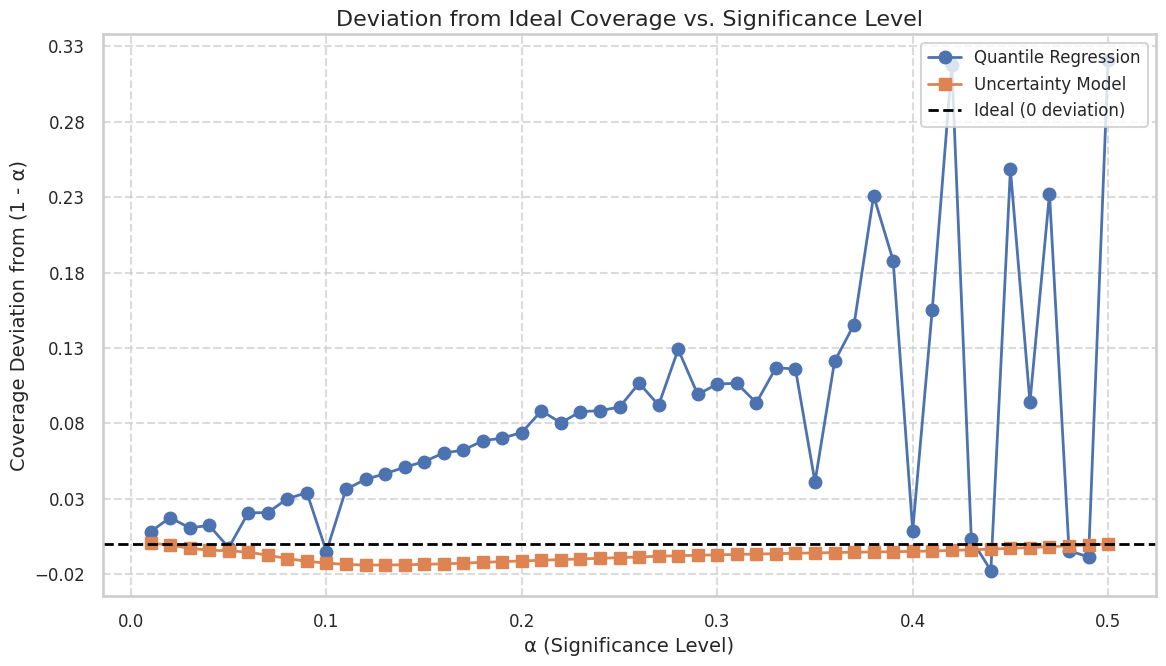

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate deviations from ideal coverage
deviation_qr = np.array(cvg_quantile_reg) - (1 - alpha)
deviation_uncertainty = np.array(cvg_uncertainty_model) - (1 - alpha)

# Plot settings
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(12, 7))

# Plot deviations
plt.plot(alpha, deviation_qr, label='Quantile Regression', marker='o', linewidth=2)
plt.plot(alpha, deviation_uncertainty, label='Uncertainty Model', marker='s', linewidth=2)

# Reference line at 0 (perfect coverage)
plt.axhline(0, color='black', linestyle='--', linewidth=2, label='Ideal (0 deviation)')

# Axis labels and title
plt.xlabel('α (Significance Level)', fontsize=14)
plt.ylabel('Coverage Deviation from (1 - α)', fontsize=14)
plt.title('Deviation from Ideal Coverage vs. Significance Level', fontsize=16)

# Custom y-axis ticks: step of 0.01
y_min = min(deviation_qr.min(), deviation_uncertainty.min())
y_max = max(deviation_qr.max(), deviation_uncertainty.max())
y_ticks = np.arange(np.floor(y_min * 100) / 100, np.ceil(y_max * 100) / 100 + 0.01, 0.05)
plt.yticks(y_ticks)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12, loc='upper right')

# Show plot
plt.tight_layout()
plt.savefig('Images/deviation from ideal coverage.png', dpi=300)
plt.show()


### Jackknife, Jackknife+ Method - Full Conformal Prediction

In [14]:
X_train_bias = torch.cat([X_train, torch.ones((X_train.shape[0], 1), device=device)], dim=1)
X_test_bias = torch.cat([X_test, torch.ones((X_test.shape[0], 1), device=device)], dim=1)

# Compute (X^T X)^-1 X^T y using torch
A = X_train_bias.T @ X_train_bias            # X^T X
A_inv = torch.inverse(A)                     # (X^T X)^-1
w = A_inv @ X_train_bias.T @ y_train         # (X^T X)^-1 X^T y

In [15]:
score_array = torch.zeros(X_train_bias.shape[0], dtype=torch.float32)

for i in range(len(X_train_bias)):
    x = X_train_bias[i].unsqueeze(0)  # Shape: (1, D)
    y = y_train[i]

    # x: (1, D), x.T: (D, 1), A_inv: (D, D)
    numerator = A_inv @ x.T @ x @ A_inv
    denominator = 1 - (x @ A_inv @ x.T)

    if denominator.item() == 0:
        y_pred = x @ w
        score_array[i] = torch.abs(y_pred - y)
    else:
        A_inv_new = A_inv + numerator / denominator
        residual = y - x @ w
        w_new = w - A_inv_new @ x.T @ residual
        y_pred = x @ w_new
        score_array[i] = torch.abs(y_pred - y)

Refer to Sherman-Morrison Update to add and remove efficiently in Linear Regression

In [16]:
def getCvgJackknife(alpha):
    # Compute quantile index and value using PyTorch
    index = math.ceil((len(score_array) + 1) * (1 - alpha)) / len(score_array)
    q_hat = torch.quantile(score_array, torch.tensor(index, dtype=torch.float32))

    # Predict with the linear model
    y_test_pred = X_test_bias @ w

    # Compute coverage
    coverage = (y_test >= (y_test_pred - q_hat)) & (y_test <= (y_test_pred + q_hat))
    coverage_percentage = coverage.float().mean() * 100

    return coverage_percentage

In [17]:
def getCvgJackknife_plus(alpha):
    score_dict = [[] for _ in range(len(X_test_bias))]

    for i in range(len(X_train_bias)):
        x = X_train_bias[i].unsqueeze(0)  # Shape: (1, D)
        y = y_train[i].unsqueeze(0)       # Shape: (1,)

        denominator = 1 - (x @ A_inv @ x.T)
        if denominator.item() == 0:
            w_new = w
        else:
            numerator = A_inv @ x.T @ x @ A_inv
            A_inv_new = A_inv + numerator / denominator
            residual = y - x @ w
            w_new = w - A_inv_new @ x.T @ residual

        for j in range(len(X_test_bias)):
            test_pred = X_test_bias[j].unsqueeze(0) @ w_new
            score = torch.abs(test_pred - score_array[i])
            score_dict[j].append(score.item())

    coverage = 0
    for i in range(len(X_test_bias)):
        scores = torch.tensor(score_dict[i])
        n = len(scores)

        index_up = math.ceil((n + 1) * (1 - alpha)) / n
        index_low = math.floor((n + 1) * alpha) / n

        q_lower = torch.quantile(scores, q=index_low)
        q_upper = torch.quantile(scores, q=index_up)

        y_pred = X_test_bias[i].unsqueeze(0) @ w
        y_actual = y_test[i]

        lower_bound = y_pred - q_upper
        upper_bound = y_pred + q_lower

        if (y_actual >= lower_bound) and (y_actual <= upper_bound):
            coverage += 1

    coverage_percentage = (coverage / len(X_test_bias)) * 100
    return coverage_percentage

In [18]:
# getCvgJackknife(0.1)

In [19]:
# getCvgJackknife_plus(0.1)